<a href="https://colab.research.google.com/github/tbfelder/deep_learning/blob/master/ConvolutionalAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/modules/')
import hologram

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


ModuleNotFoundError: ignored

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly-gpu-2.0-preview
except Exception:
  pass
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import scipy

import os
import time
import matplotlib.pyplot as plt

In [0]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard

In [0]:
N = 128
encoded_dim = int(N/((2**3)))

In [0]:
input_img = Input(shape=(N,N,1))

x = Conv2D(64, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x) # (bs, 28, 28, 16)
x = MaxPooling2D((2,2), padding='same')(x) # (bs, 14, 14, 16)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x) # (bs, 14, 14, 8)
x = MaxPooling2D((2,2), padding='same')(x) # (bs, 7, 7, 8)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x) # (bs, 7, 7, 8)
encoded = MaxPooling2D((2,2), padding='same')(x) # (bs, 4, 4, 8)

l1 = Conv2D(8, (3,3), activation='relu', padding='same') # (bs, 4, 4, 8)
l2 = UpSampling2D((2,2)) # (bs, 8, 8, 8)
l3 = Conv2D(16, (3,3), activation='relu', padding='same') # (bs, 8, 8, 8)
l4 = UpSampling2D((2,2)) # (bs, 16, 16, 8)
l5 = Conv2D(32, (3,3), activation='relu', padding='same') # (bs, 16, 16, 16)
l6 = UpSampling2D((2,2)) # (bs, 32, 32, 16)
l7 = Conv2D(64, (3,3), activation='relu', padding='same') # (bs, 16, 16, 16)
l8 = UpSampling2D((2,2)) # (bs, 32, 32, 16)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same') # (bs, 32, 32, 1)

autoencoder = Model(input_img, decoded(l8(l7(l6(l5(l4(l3(l2(l1(encoded))))))))))
adam = tf.keras.optimizers.Adam(lr=3*(10**(-4)))
autoencoder.compile(optimizer=adam, loss='binary_crossentropy')


encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoded_dim, encoded_dim, 8))
decoder = Model(encoded_input, decoded(l8(l7(l6(l5(l4(l3(l2(l1(encoded_input))))))))))

In [0]:
autoencoder.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 64, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 16)        0  

In [0]:
MNIST = np.load('/content/gdrive/My Drive/Colab Notebooks/data/MNIST.npy')
MNIST = hologram.embedding_images(MNIST, imsize=128, zoom=2) / 255.0

x_train = tf.cast(MNIST[:9000], dtype=tf.float32)
x_test = tf.cast(MNIST[9000:], dtype=tf.float32)

In [0]:
hist = autoencoder.fit(x_train, x_train,
               epochs=15,
               batch_size=16,
               shuffle=True,
               validation_data=(x_test, x_test))

Train on 9000 samples, validate on 1000 samples
Epoch 1/15
9000/9000 [==============================] - 16s 2ms/sample - loss: 0.0916 - val_loss: 0.0395
Epoch 2/15
9000/9000 [==============================] - 9s 990us/sample - loss: 0.0362 - val_loss: 0.0331
Epoch 3/15
9000/9000 [==============================] - 9s 994us/sample - loss: 0.0319 - val_loss: 0.0307
Epoch 4/15
9000/9000 [==============================] - 9s 997us/sample - loss: 0.0301 - val_loss: 0.0295
Epoch 5/15
9000/9000 [==============================] - 9s 995us/sample - loss: 0.0289 - val_loss: 0.0285
Epoch 6/15
9000/9000 [==============================] - 9s 988us/sample - loss: 0.0280 - val_loss: 0.0275
Epoch 7/15
9000/9000 [==============================] - 9s 994us/sample - loss: 0.0273 - val_loss: 0.0270
Epoch 8/15
9000/9000 [==============================] - 9s 988us/sample - loss: 0.0267 - val_loss: 0.0264
Epoch 9/15
9000/9000 [==============================] - 9s 999us/sample - loss: 0.0262 - val_loss: 0.0261

In [0]:
def plot_res(inp_img, results, n=10):
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # display original
      ax = plt.subplot(2, n, i+1)
      x = tf.squeeze(inp_img[i], axis=-1)
      hologram.imshow(x)
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      x_decoded = tf.squeeze(results[i], axis=-1)
      hologram.imshow(x_decoded)
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  #plt.savefig(outputpath+'InputAutoEncoder_N'+str(N)+'_samples')

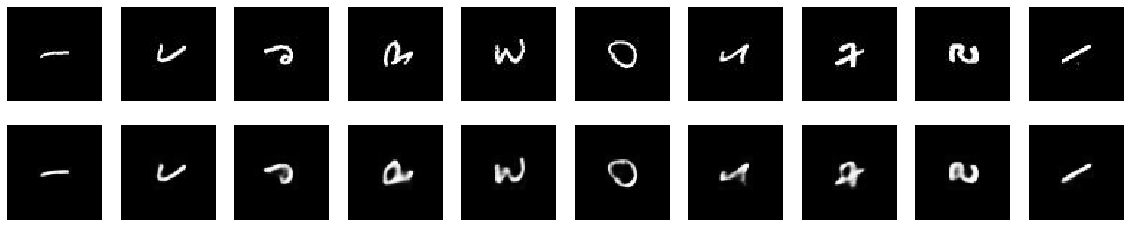

In [0]:
decoded_imgs = decoder(encoder(x_test))
plot_res(x_test, decoded_imgs)

In [0]:
x_noisy = x_test + tf.random.normal( tf.shape(x_test), mean=0.0, stddev=0.1)

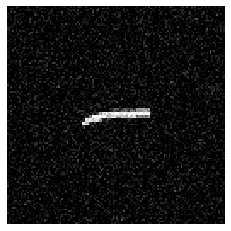

In [0]:
hologram.imshow(x_noisy[0])

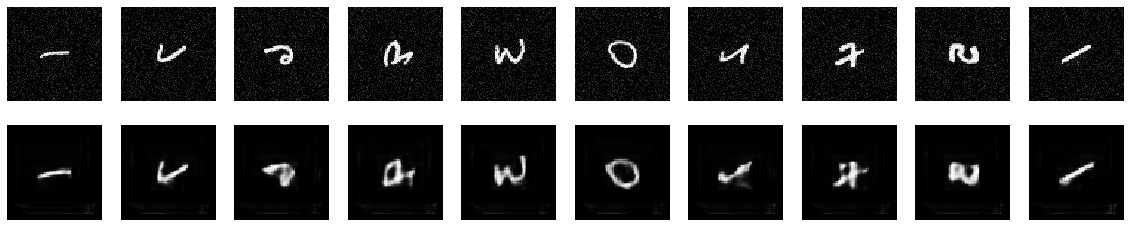

In [0]:
decoded_noisy = decoder(encoder(x_noisy))
plot_res(x_noisy, decoded_noisy)

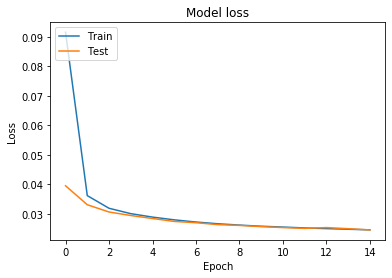

In [0]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
encoder.save('/content/gdrive/My Drive/Colab Notebooks/AssistingCode/ConvEncoder.h5')
#decoder.save('InputDecoder.h5')